##DYNAMIC CORRELATION GRAPH

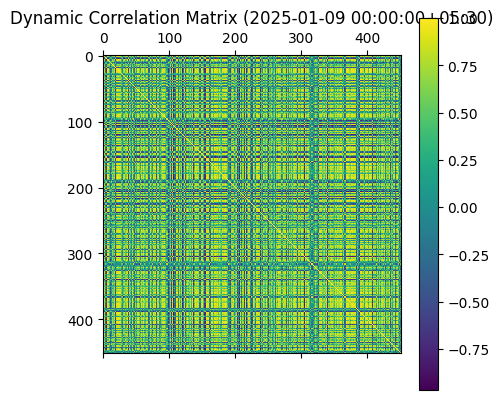

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file
df = pd.read_csv('/Users/garbhapudinesh/Desktop/DSTASKS/Task1Data.csv', parse_dates=['Date'])

# Extract unique stocks and sectors
stocks = df['Stock'].unique()
sectors = df.groupby('Stock')['sector'].first().to_dict()

# Function to compute dynamic correlations
def compute_dynamic_correlations(df, window=20):
    correlations = {}
    dates = df['Date'].unique()
    
    for i in range(window, len(dates)):
        window_data = df[(df['Date'] >= dates[i-window]) & (df['Date'] <= dates[i])]
        pivot_data = window_data.pivot(index='Date', columns='Stock', values='Close')
        corr_matrix = pivot_data.corr(method='pearson')
        correlations[dates[i]] = corr_matrix.fillna(0)  # Ensure no NaN values
        
    return correlations

# Compute dynamic correlations
corr_dict = compute_dynamic_correlations(df)

# Create dictionaries to store correlations
intra_corr_dict = {}
inter_corr_dict = {}

# Compute intra- and inter-sector correlations
for date, corr_matrix in corr_dict.items():
    intra_corr = {}
    inter_corr = {}

    for stock in stocks:
        sector = sectors[stock]
        same_sector = [s for s in stocks if sectors[s] == sector and s != stock]
        diff_sector = [s for s in stocks if sectors[s] != sector]

        intra_corr[stock] = corr_matrix.loc[stock, same_sector].mean() if same_sector else 0
        inter_corr[stock] = corr_matrix.loc[stock, diff_sector].mean() if diff_sector else 0

    intra_corr_dict[date] = intra_corr
    inter_corr_dict[date] = inter_corr

# Convert correlation dictionaries to DataFrames
intra_corr_df = pd.DataFrame(intra_corr_dict).T.reset_index().melt(id_vars=['index'], var_name='Stock', value_name='intra_corr')
inter_corr_df = pd.DataFrame(inter_corr_dict).T.reset_index().melt(id_vars=['index'], var_name='Stock', value_name='inter_corr')

# Merge back into the original DataFrame
df = df.merge(intra_corr_df, left_on=['Date', 'Stock'], right_on=['index', 'Stock'], how='left').drop(columns=['index'])
df = df.merge(inter_corr_df, left_on=['Date', 'Stock'], right_on=['index', 'Stock'], how='left').drop(columns=['index'])

# Ensure 'intra_corr' and 'inter_corr' exist and fill missing values with 0
df[['intra_corr', 'inter_corr']] = df[['intra_corr', 'inter_corr']].fillna(0)

# Feature scaling using MinMaxScaler
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MVA_5', 'MVA_10', 'MVA_15', 
            'MVA_20', 'MVA_25', 'MVA_30', 'pc_open', 'pc_high', 'pc_low', 
            'intra_corr', 'inter_corr']

# Check if all features exist before scaling
existing_features = [f for f in features if f in df.columns]

scaler = MinMaxScaler()
df[existing_features] = scaler.fit_transform(df[existing_features])

# Visualize a sample correlation matrix (optional)
latest_date = max(corr_dict.keys())  # Get the latest date in the correlation dictionary
plt.matshow(corr_dict[latest_date])
plt.title(f'Dynamic Correlation Matrix ({latest_date})')
plt.colorbar()
plt.show()


##R-LEARNING

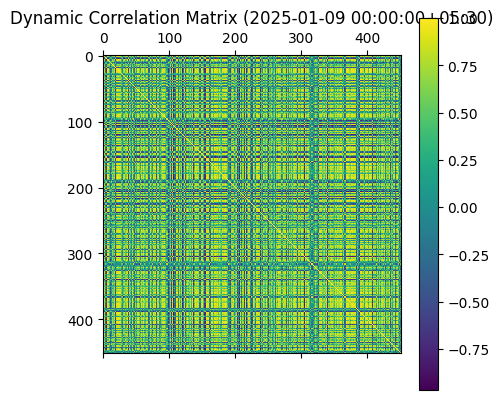

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/100, Total Reward: 18.13
Episode 2/100, Total Reward: -0.89
Episode 3/100, Total Reward: 0.15
Episode 4/100, Total Reward: -0.71
Episode 5/100, Total Reward: -0.72
Episode 6/100, Total Reward: 0.65
Episode 7/100, Total Reward: 0.85
Episode 8/100, Total Reward: -0.49
Episode 9/100, Total Reward: 0.41
Episode 10/100, Total Reward: -0.87
Episode 11/100, Total Reward: 0.86
Episode 12/100, Total Reward: 0.90
Episode 13/100, Total Reward: 0.10
Episode 14/100, Total Reward: -0.39
Episode 15/100, Total Reward: -0.56
Episode 16/100, Total Reward: 0.05
Episode 17/100, Total Reward: -0.21
Episode 18/100, Total Reward: -0.96
Episode 19/100, Total Reward: -0.18
Episode 20/100, Total Reward: -0.92
Episode 21/100, Total Reward: 0.71
Episode 22/100, Total Reward: -0.07
Episode 23/100, Total Reward: -1.00
Episode 24/100, Total Reward: 0.04
Episode 25/100, Total Reward: 0.77
Episode 26/100, Total Reward: -0.50
Episode 27/100, Total Reward: 0.95
Episode 28/100, Total Reward: -0.76
Episode 29/10

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gym
from gym import spaces
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Load the CSV file
df = pd.read_csv('/Users/garbhapudinesh/Desktop/DSTASKS/Task1Data.csv', parse_dates=['Date'])

# Extract unique stocks and sectors
stocks = df['Stock'].unique()
if len(stocks) == 0:
    raise ValueError("No stocks found in the dataset!")

sectors = df.groupby('Stock')['sector'].first().to_dict()

# Function to compute dynamic correlations
def compute_dynamic_correlations(df, window=20):
    correlations = {}
    dates = df['Date'].unique()
    
    for i in range(window, len(dates)):
        window_data = df[(df['Date'] >= dates[i-window]) & (df['Date'] <= dates[i])]
        pivot_data = window_data.pivot(index='Date', columns='Stock', values='Close')
        corr_matrix = pivot_data.corr(method='pearson').fillna(0)  # Ensure no NaN values
        correlations[dates[i]] = corr_matrix
        
    return correlations

# Compute dynamic correlations
corr_dict = compute_dynamic_correlations(df)

# Create dictionaries to store correlations
intra_corr_dict = {}
inter_corr_dict = {}

# Compute intra- and inter-sector correlations
for date, corr_matrix in corr_dict.items():
    intra_corr = {}
    inter_corr = {}

    for stock in stocks:
        sector = sectors[stock]
        same_sector = [s for s in stocks if sectors[s] == sector and s != stock]
        diff_sector = [s for s in stocks if sectors[s] != sector]

        intra_corr[stock] = corr_matrix.loc[stock, same_sector].mean() if same_sector else 0
        inter_corr[stock] = corr_matrix.loc[stock, diff_sector].mean() if diff_sector else 0

    intra_corr_dict[date] = intra_corr
    inter_corr_dict[date] = inter_corr

# Convert correlation dictionaries to DataFrames
intra_corr_df = pd.DataFrame(intra_corr_dict).T.reset_index().melt(id_vars=['index'], var_name='Stock', value_name='intra_corr')
inter_corr_df = pd.DataFrame(inter_corr_dict).T.reset_index().melt(id_vars=['index'], var_name='Stock', value_name='inter_corr')

# Merge back into the original DataFrame
df = df.merge(intra_corr_df, left_on=['Date', 'Stock'], right_on=['index', 'Stock'], how='left').drop(columns=['index'])
df = df.merge(inter_corr_df, left_on=['Date', 'Stock'], right_on=['index', 'Stock'], how='left').drop(columns=['index'])

# Ensure 'intra_corr' and 'inter_corr' exist and fill missing values with 0
df[['intra_corr', 'inter_corr']] = df[['intra_corr', 'inter_corr']].fillna(0)

# Feature scaling using MinMaxScaler
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MVA_5', 'MVA_10', 'MVA_15', 
            'MVA_20', 'MVA_25', 'MVA_30', 'pc_open', 'pc_high', 'pc_low', 
            'intra_corr', 'inter_corr']

# Check if all features exist before scaling
existing_features = [f for f in features if f in df.columns]

scaler = MinMaxScaler()
df[existing_features] = scaler.fit_transform(df[existing_features])

# Visualization (Optional)
latest_date = max(corr_dict.keys())  # Get the latest date in the correlation dictionary
plt.matshow(corr_dict[latest_date])
plt.title(f'Dynamic Correlation Matrix ({latest_date})')
plt.colorbar()
plt.show()

### Stock Trading Environment ###
class StockTradingEnv(gym.Env):
    def __init__(self, df, embeddings=None):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.done = False
        self.embeddings = embeddings if embeddings else {}

        # Define action and state space
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(17,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][existing_features].values
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            self.done = True
        
        reward = random.uniform(-1, 1)  # Placeholder reward function
        return self._next_observation(), reward, self.done, {}

### Deep Q-Network (DQN) Agent ###
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(24, activation='relu', input_dim=self.state_size),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training
if 'embeddings' not in locals():
    embeddings = {}  # Ensure embeddings exist

env = StockTradingEnv(df[df['Stock'] == stocks[0]], embeddings)  # Single stock for simplicity
agent = DQNAgent(state_size=len(existing_features), action_size=3)

episodes = 100
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.2f}")



In [ ]:
##LSTM

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# Load and preprocess data
df.head()
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MVA_5', 'MVA_10', 'MVA_15', 
            'MVA_20', 'MVA_25', 'MVA_30', 'pc_open', 'pc_high', 'pc_low', 
            'intra_corr', 'inter_corr']

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Split data into training and testing sets (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Stock"])

# Function to create sequences for LSTM
def create_sequences(data, seq_length=20):
    X = []
    for stock in data['Stock'].unique():

        stock_data = data[data['Stock'] == stock][features].values
        for i in range(len(stock_data) - seq_length):
            X.append(stock_data[i:i+seq_length])
    return np.array(X)

seq_length = 20

# Create LSTM input sequences
X_train = create_sequences(train_df, seq_length)
X_test = create_sequences(test_df, seq_length)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, len(features))),
    LSTM(32),
    Dense(16, activation='relu')  # Embedding layer
])
model.compile(optimizer='adam', loss='mse')

# Train model using training data only
model.fit(X_train, X_train[:, -1, :], epochs=10, batch_size=32, validation_data=(X_test, X_test[:, -1, :]))

# Generate embeddings for training and testing sets
train_embeddings = model.predict(X_train)
test_embeddings = model.predict(X_test)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: nan - val_loss: nan
Epoch 2/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 3/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 4/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 5/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 6/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 7/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: nan - val_loss: nan
Epoch 8/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: nan - val_loss: nan
Epoch 9/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: nan - val_loss: nan
Epoch 10/10
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: nan - val_loss: nan
8073/8073 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Train Embeddings Shape: (258332, 16)
Test Embeddings Shape: (57819, 16)


##R-LEARNING WITH RANKS

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
from collections import deque

# Hyperparameters for RL
GAMMA = 0.95      # Discount factor
EPSILON = 1.0     # Initial exploration rate
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MEMORY_SIZE = 2000

# Define DQN Model for Buy/Sell Decisions
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # Embedding vector size
        self.action_size = action_size  # 2 actions: Buy (1), Sell (0)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON
        self.gamma = GAMMA
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY

        # Create DQN model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(64, activation="relu", input_dim=self.state_size),
            Dense(32, activation="relu"),
            Dense(self.action_size, activation="linear")  # Output layer: 2 neurons (Buy/Sell)
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model

    # Store experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Take action based on ε-greedy policy
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])  # Explore: Random action
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])  # Exploit: Choose best action

    # Train the model using replay memory
    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return  # Wait until memory fills

        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])

            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target

            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Prepare Data for RL
state_size = train_embeddings.shape[1]  # Size of LSTM embedding vector
action_size = 2  # Buy (1) or Sell (0)
agent = DQNAgent(state_size, action_size)

# Simulated training loop for reinforcement learning
EPISODES = 50
for e in range(EPISODES):
    for i in range(len(train_embeddings) - 1):
        state = train_embeddings[i]
        next_state = train_embeddings[i + 1]
        
        # Simulated reward: Higher return ratio → better reward
        reward = train_df["return_ratio"].iloc[i]
        
        # Assume done flag at the last timestep
        done = i == len(train_embeddings) - 2
        
        action = agent.act(state)
        agent.remember(state, action, reward, next_state, done)
        
        if done:
            print(f"Episode {e+1}/{EPISODES} - Epsilon: {agent.epsilon:.4f}")

    agent.replay()  # Train the model after each episode

# Predict Buy/Sell for Test Data
predicted_actions = [agent.act(test_embeddings[i]) for i in range(len(test_embeddings))]

# Align test_df with test_embeddings
test_df_filtered = test_df.iloc[:len(test_embeddings)].copy()
test_df_filtered["Action"] = predicted_actions

# Predict Top K Stocks Based on Return Ratio
K = 10
top_k_stocks = test_df_filtered.sort_values(by="return_ratio", ascending=False).head(K)

print("Top K Stocks to Buy:")
print(top_k_stocks[["Stock", "return_ratio", "Action"]])


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/50 - Epsilon: 1.0000
Episode 2/50 - Epsilon: 0.9950
Episode 3/50 - Epsilon: 0.9900
Episode 4/50 - Epsilon: 0.9851
Episode 5/50 - Epsilon: 0.9801
Episode 6/50 - Epsilon: 0.9752
Episode 7/50 - Epsilon: 0.9704
Episode 8/50 - Epsilon: 0.9655
Episode 9/50 - Epsilon: 0.9607
Episode 10/50 - Epsilon: 0.9559
Episode 11/50 - Epsilon: 0.9511
Episode 12/50 - Epsilon: 0.9464
Episode 13/50 - Epsilon: 0.9416
Episode 14/50 - Epsilon: 0.9369
Episode 15/50 - Epsilon: 0.9322
Episode 16/50 - Epsilon: 0.9276
Episode 17/50 - Epsilon: 0.9229
Episode 18/50 - Epsilon: 0.9183
Episode 19/50 - Epsilon: 0.9137
Episode 20/50 - Epsilon: 0.9092
Episode 21/50 - Epsilon: 0.9046
Episode 22/50 - Epsilon: 0.9001
Episode 23/50 - Epsilon: 0.8956
Episode 24/50 - Epsilon: 0.8911
Episode 25/50 - Epsilon: 0.8867
Episode 26/50 - Epsilon: 0.8822
Episode 27/50 - Epsilon: 0.8778
Episode 28/50 - Epsilon: 0.8734
Episode 29/50 - Epsilon: 0.8691
Episode 30/50 - Epsilon: 0.8647
Episode 31/50 - Epsilon: 0.8604
Episode 32/50 - E

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
from collections import deque

# Hyperparameters for RL
GAMMA = 0.95      # Discount factor
EPSILON = 1.0     # Initial exploration rate
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
LEARNING_RATE = 0.001
MEMORY_SIZE = 2000

# Define DQN Model for Buy/Sell Decisions
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # Embedding vector size
        self.action_size = action_size  # 2 actions: Buy (1), Sell (0)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON
        self.gamma = GAMMA
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY

        # Create DQN model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(64, activation="relu", input_dim=self.state_size),
            Dense(32, activation="relu"),
            Dense(self.action_size, activation="linear")  # Output layer: 2 neurons (Buy/Sell)
        ])
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model

    # Store experience in replay memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Take action based on ε-greedy policy
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1])  # Explore: Random action
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])  # Exploit: Choose best action

    # Train the model using replay memory
    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return  # Wait until memory fills

        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0])

            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target

            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Prepare Data for RL
state_size = train_embeddings.shape[1]  # Size of LSTM embedding vector
action_size = 2  # Buy (1) or Sell (0)
agent = DQNAgent(state_size, action_size)

# Simulated training loop for reinforcement learning
EPISODES = 50
for e in range(EPISODES):
    for i in range(len(train_embeddings) - 1):
        state = train_embeddings[i]
        next_state = train_embeddings[i + 1]
        
        # Simulated reward: Higher return ratio → better reward
        reward = train_df["return_ratio"].iloc[i]
        
        # Assume done flag at the last timestep
        done = i == len(train_embeddings) - 2
        
        action = agent.act(state)
        agent.remember(state, action, reward, next_state, done)
        
        if done:
            print(f"Episode {e+1}/{EPISODES} - Epsilon: {agent.epsilon:.4f}")

    agent.replay()  # Train the model after each episode

# Predict Buy/Sell for Test Data
predicted_actions = [agent.act(test_embeddings[i]) for i in range(len(test_embeddings))]

# Align test_df with test_embeddings
test_df_filtered = test_df.iloc[:len(test_embeddings)].copy()
test_df_filtered["Action"] = predicted_actions

# Predict Top K Stocks Based on Return Ratio
K = 5
top_k_stocks = test_df_filtered.sort_values(by="return_ratio", ascending=False).head(K)

print("Top K Stocks to Buy:")
print(top_k_stocks[["Stock", "return_ratio", "Action"]])


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/50 - Epsilon: 1.0000
Episode 2/50 - Epsilon: 0.9950
Episode 3/50 - Epsilon: 0.9900
Episode 4/50 - Epsilon: 0.9851
Episode 5/50 - Epsilon: 0.9801
Episode 6/50 - Epsilon: 0.9752
Episode 7/50 - Epsilon: 0.9704
Episode 8/50 - Epsilon: 0.9655
Episode 9/50 - Epsilon: 0.9607
Episode 10/50 - Epsilon: 0.9559
Episode 11/50 - Epsilon: 0.9511
Episode 12/50 - Epsilon: 0.9464
Episode 13/50 - Epsilon: 0.9416
Episode 14/50 - Epsilon: 0.9369
Episode 15/50 - Epsilon: 0.9322
Episode 16/50 - Epsilon: 0.9276
Episode 17/50 - Epsilon: 0.9229
Episode 18/50 - Epsilon: 0.9183
Episode 19/50 - Epsilon: 0.9137
Episode 20/50 - Epsilon: 0.9092
Episode 21/50 - Epsilon: 0.9046
Episode 22/50 - Epsilon: 0.9001
Episode 23/50 - Epsilon: 0.8956
Episode 24/50 - Epsilon: 0.8911
Episode 25/50 - Epsilon: 0.8867
Episode 26/50 - Epsilon: 0.8822
Episode 27/50 - Epsilon: 0.8778
Episode 28/50 - Epsilon: 0.8734
Episode 29/50 - Epsilon: 0.8691
Episode 30/50 - Epsilon: 0.8647
Episode 31/50 - Epsilon: 0.8604
Episode 32/50 - E

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error
import numpy as np

# Top K ground truth buys
K = 10
ideal_buys = test_df_filtered.sort_values(by="return_ratio", ascending=False).head(K)
ideal_buy_stocks = set(ideal_buys["Stock"])

# Predicted buys
predicted_buy_df = test_df_filtered[test_df_filtered["Action"] == 1]
predicted_buy_stocks = set(predicted_buy_df["Stock"])

# ----- Precision -----
true_positives = len(ideal_buy_stocks & predicted_buy_stocks)
precision = true_positives / len(predicted_buy_stocks) if predicted_buy_stocks else 0

# ----- Accuracy -----
ideal_actions = test_df_filtered["Stock"].apply(lambda stock: 1 if stock in ideal_buy_stocks else 0)
accuracy = accuracy_score(ideal_actions, test_df_filtered["Action"])

# ----- MRR -----
ranked_predicted_buys = predicted_buy_df.sort_values(by="return_ratio", ascending=False).reset_index()
reciprocal_ranks = []

for stock in ideal_buy_stocks:
    if stock in ranked_predicted_buys["Stock"].values:
        rank = ranked_predicted_buys[ranked_predicted_buys["Stock"] == stock].index[0] + 1
        reciprocal_ranks.append(1 / rank)

mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0

# ----- MAE -----
# MAE between predicted return ratios and true top-K return ratios
mae = mean_absolute_error(
    y_true=ideal_buys["return_ratio"].values[:len(predicted_buy_df)],
    y_pred=predicted_buy_df.sort_values(by="return_ratio", ascending=False)["return_ratio"].values[:K]
) if not predicted_buy_df.empty else 0

# ----- Display Results -----
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Precision: 0.0222
Accuracy: 0.6080
Mean Reciprocal Rank (MRR): 0.2774
Mean Absolute Error (MAE): 0.0008


In [15]:
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error
import numpy as np

# Top K ground truth buys
K = 10
ideal_buys = test_df_filtered.sort_values(by="return_ratio", ascending=False).head(K)
ideal_buy_stocks = set(ideal_buys["Stock"])

# Predicted buys
predicted_buy_df = test_df_filtered[test_df_filtered["Action"] == 1]
predicted_buy_stocks = set(predicted_buy_df["Stock"])

# ----- Precision -----
true_positives = len(ideal_buy_stocks & predicted_buy_stocks)
precision = true_positives / len(predicted_buy_stocks) if predicted_buy_stocks else 0

# ----- Accuracy -----
ideal_actions = test_df_filtered["Stock"].apply(lambda stock: 1 if stock in ideal_buy_stocks else 0)
accuracy = accuracy_score(ideal_actions, test_df_filtered["Action"])

# ----- MRR -----
ranked_predicted_buys = predicted_buy_df.sort_values(by="return_ratio", ascending=False).reset_index()
reciprocal_ranks = []

for stock in ideal_buy_stocks:
    if stock in ranked_predicted_buys["Stock"].values:
        rank = ranked_predicted_buys[ranked_predicted_buys["Stock"] == stock].index[0] + 1
        reciprocal_ranks.append(1 / rank)

mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0

# ----- MAE -----
# MAE between predicted return ratios and true top-K return ratios
mae = mean_absolute_error(
    y_true=ideal_buys["return_ratio"].values[:len(predicted_buy_df)],
    y_pred=predicted_buy_df.sort_values(by="return_ratio", ascending=False)["return_ratio"].values[:K]
) if not predicted_buy_df.empty else 0

# ----- Display Results -----
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Precision: 0.0222
Accuracy: 0.6053
Mean Reciprocal Rank (MRR): 0.2728
Mean Absolute Error (MAE): 0.0009
